# **PIA**

*   Oscar Daniel Leal Maldonado
*   Andres Eduaro Lee Martinez
*   Ramiro Gracia Diaz






# **LOAD** **LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.applications import mobilenet_v2

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

# **LOAD DATA**

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input/the-iqothnccd-lung-cancer-dataset/The-IQ-OTHNCCD-lung-cancer-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset
!unzip the-iqothnccd-lung-cancer-dataset.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
 99% 148M/149M [00:08<00:00, 17.7MB/s]
100% 149M/149M [00:08<00:00, 18.4MB/s]
Archive:  the-iqothnccd-lung-cancer-dataset.zip
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (102).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg  
  inflating: The IQ-OTHNCCD lung cancer 

In [ ]:
benign_dirs = [
    r'/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
]

Malignant_dir = [ r'/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases']

Normal_dirs = [
    r'/content/The IQ-OTHNCCD lung cancer dataset/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  /content/The IQ-OTHNCCD lung cancer dataset/Be...  benign
1  /content/The IQ-OTHNCCD lung cancer dataset/Be...  benign
2  /content/The IQ-OTHNCCD lung cancer dataset/Be...  benign
3  /content/The IQ-OTHNCCD lung cancer dataset/Be...  benign
4  /content/The IQ-OTHNCCD lung cancer dataset/Be...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [ ]:
Lung_df.shape

(1097, 2)

In [ ]:
train_images, test_images = train_test_split(Lung_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(877, 2)
(220, 2)
(220, 2)
(877, 2)


# **DATA PREPROCESSING**

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )


Found 877 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


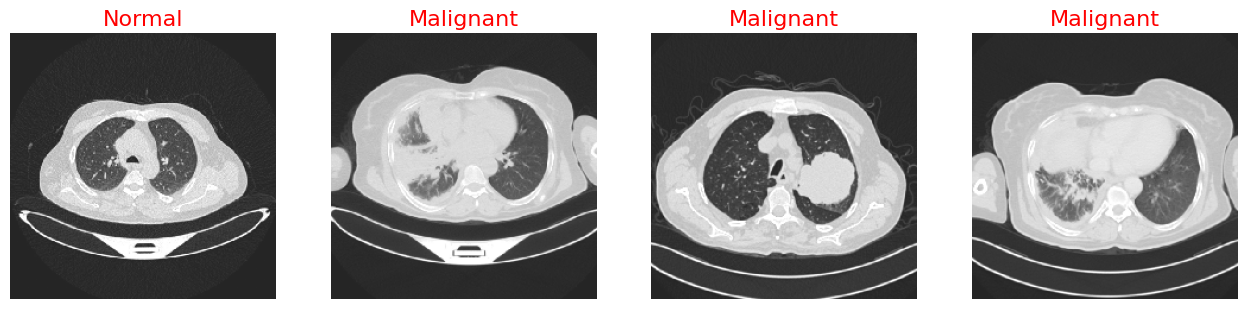

In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="Red",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

**Para imagenes de color**

# **MODEL SELECTION AND TRAINING**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 73, 73, 64)        12352     
                                                                 
 batch_normalization_36 (Ba  (None, 73, 73, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 36, 36, 128)       204928    
                                                                 
 batch_normalization_37 (Ba  (None, 36, 36, 128)       512       
 tchNormalization)                                               
                                                      

In [ ]:

history = model.fit(train, epochs=10, validation_data=val, verbose=1)


Epoch 1/10
220/220 [==============================] - 137s 623ms/step - loss: 0.5303 - accuracy: 0.7879 - val_loss: 0.2921 - val_accuracy: 0.9318
Epoch 2/10
220/220 [==============================] - 139s 631ms/step - loss: 0.3265 - accuracy: 0.8780 - val_loss: 0.1853 - val_accuracy: 0.9364
Epoch 3/10
220/220 [==============================] - 137s 622ms/step - loss: 0.2722 - accuracy: 0.9042 - val_loss: 0.1645 - val_accuracy: 0.9364
Epoch 4/10
220/220 [==============================] - 139s 632ms/step - loss: 0.2169 - accuracy: 0.9065 - val_loss: 0.1203 - val_accuracy: 0.9636
Epoch 5/10
220/220 [==============================] - 136s 617ms/step - loss: 0.1726 - accuracy: 0.9361 - val_loss: 0.1005 - val_accuracy: 0.9545
Epoch 6/10
220/220 [==============================] - 139s 630ms/step - loss: 0.1425 - accuracy: 0.9441 - val_loss: 0.0715 - val_accuracy: 0.9682
Epoch 7/10
220/220 [==============================] - 136s 617ms/step - loss: 0.0941 - accuracy: 0.9612 - val_loss: 0.0963 -

In [ ]:
model.evaluate(test, verbose=1)

55/55 [==============================] - 13s 244ms/step - loss: 0.0428 - accuracy: 0.9818


[0.042840421199798584, 0.9818181991577148]

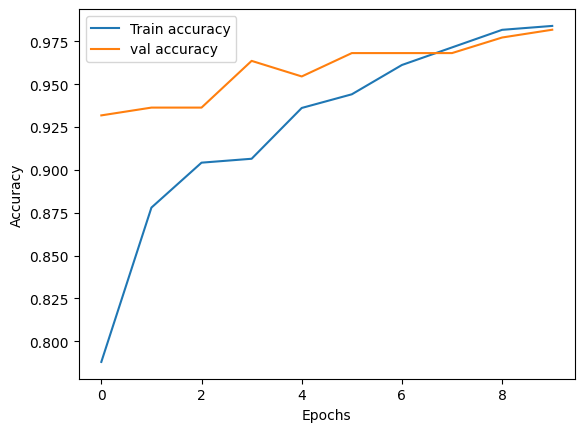

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')

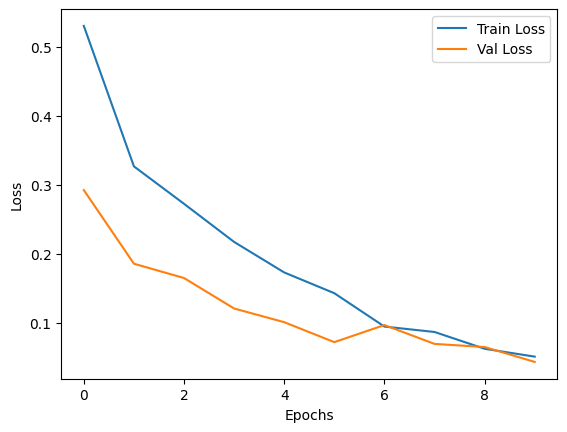

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')

# **MODEL TEST**

In [ ]:
predictions = model.predict(test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test.labels

# Obtener todas las imágenes de test
all_test_images = []
for i in range(len(test)):
    all_test_images.append(test[i][0])
all_test_images = np.concatenate(all_test_images, axis=0)

# Definir las funciones para plotear
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow((img + 1) / 2)  # Escalar las imágenes de nuevo para mostrar

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                          100 * np.max(predictions_array),
                                          classes[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(3))  # Cambiado a 3 clases
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

55/55 [==============================] - 11s 193ms/step


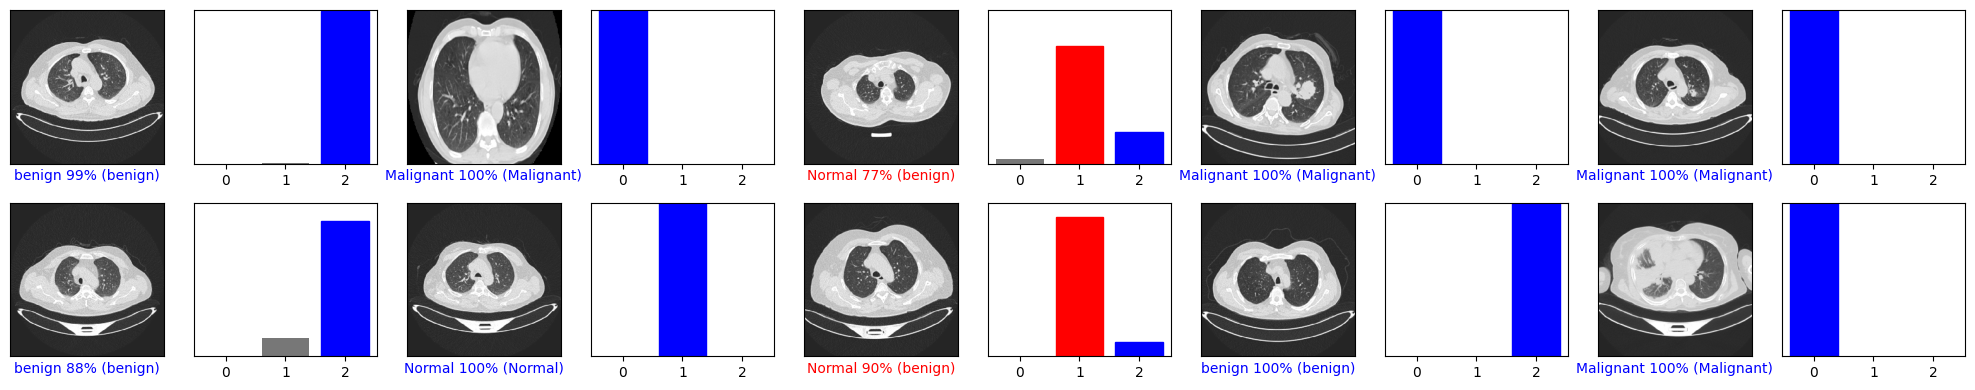

In [ ]:
num_rows = 2
num_cols = 5
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], true_labels, all_test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], true_labels)
plt.tight_layout()
plt.show()